In [31]:
import os
import sys
from chordUtils import json2lab
from subprocess import call
import json
import argparse
import chordUtils
import essentia.standard
import vamp
import numpy as np
import re
import pandas as pd
import math
import time

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from scipy.misc import logsumexp
from sklearn.model_selection import KFold


sns.set(style="white", context="talk")
degrees=['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII']
allkinds=np.array(['maj', 'min', 'dom', 'hdim7', 'dim'])

def normalize(chromas, norm='l1'):
    data = chromas
    data=preprocessing.normalize(chromas, norm=norm)
    return data

def logNormalize(chromas):
    data = chromas
    data[data == 0] = np.exp(-10)
    data=np.log(preprocessing.normalize(chromas, norm='l1'))
    #data=preprocessing.normalize(chromas, norm='l1')

    # '/1000' is a hack in order to eliminate zero deviation.
    data[data < -10.0] = -10
    data[np.isnan(data)] = -10
    data[np.isinf(data)] = -10

    return data

def imputeZeros(data):
    data[data == 0] = 0.0001 
    return preprocessing.normalize(data, norm='l1')

def toLogRatio(chromaVector) :
    res = np.zeros(11)
    product = 1.0
    for i in range(11):
        product = product * chromaVector[i]
        ii = i + 1.0
        res[i] = np.sqrt(ii / (ii + 1)) * np.log( product ** (1.0/ii) / chromaVector[i + 1])
    return res

def normalizeTo11d(chromas) :
    c = imputeZeros(chromas)
    c = np.apply_along_axis(toLogRatio, 1, chromas)
    return c

def estimateBICs(data, min_components=1, max_components=40):
    res = np.zeros(max_components - min_components + 1)
    for i in range(min_components, max_components + 1):
        gm = GaussianMixture(
            n_components=i, covariance_type='full',
            max_iter=200,
            random_state = 8)
        gm.fit(data)
        curBic = gm.bic(data)
        res[i - 1] = curBic
        if (not gm.converged_):
            print i, curBic, gm.converged_
    return res

def findOptimalNComponentsByBIC(chromas, min_components=1, max_components=40):
    fig, ax = plt.subplots(nrows=3,ncols=2)
    ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]
    res = np.zeros(5)
    for i in xrange(5):
        chordname = allkinds[i]
        samples = chromas[kinds ==chordname]
        bics = estimateBICs(samples,\
                           min_components=min_components,\
                           max_components=min(max_components, len(samples)))
        ax[i].set_title(chordname)
        ax[i].plot(bics)
        minIndex = np.argmin(bics)
        print chordname, "BIC: ", bics[minIndex], " N: ", minIndex + 1
        res[i] = minIndex + 1
    plt.show()
    return res
    
def fitMixture(data, n_components=1):
    gm = GaussianMixture(
        n_components=n_components, covariance_type='full',
        max_iter=200,
        random_state = 8)
    gm.fit(data)
    return gm

In [15]:
def violinPlots12D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'], columns=degrees)
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'], columns=degrees)
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'], columns=degrees)
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'], columns=degrees)
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'], columns=degrees)
    sns.violinplot(data=dDim, inner="point")
    plt.show()
    
def violinPlots11D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'])
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'])
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'])
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'])
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'])
    sns.violinplot(data=dDim, inner="point")
    plt.show()      

In [16]:
def removeUnclassified(list):
    (chromas, labels, kinds, mbids, start_times, durations) = list
    return (chromas[kinds != 'unclassified'],\
      labels[kinds != 'unclassified'],\
      kinds[kinds != 'unclassified'],\
      mbids[kinds != 'unclassified'],\
      start_times[kinds != 'unclassified'],\
      durations[kinds != 'unclassified'])

def kinds2nums(kinds):
    num = lambda x : np.where(allkinds == x)[0][0]
    return np.array([num(x) for x in kinds])

def nums2kinds(nums):
    return np.array([allkinds[x] for x in nums])

def fitConstModel(kinds, chromas, numbersOfComponents):
    dMaj = pd.DataFrame(data=chromas[kinds =='maj'])
    dMin = pd.DataFrame(data=chromas[kinds =='min'])
    dDom = pd.DataFrame(data=chromas[kinds =='dom'])
    dHdim = pd.DataFrame(data=chromas[kinds =='hdim7'])
    dDim = pd.DataFrame(data=chromas[kinds =='dim'])
    majGMM = fitMixture(dMaj.values, n_components=numbersOfComponents[0])
    minGMM = fitMixture(dMin.values, n_components=numbersOfComponents[1])
    domGMM = fitMixture(dDom.values, n_components=numbersOfComponents[2])
    hdimGMM = fitMixture(dHdim.values, n_components=numbersOfComponents[3])
    dimGMM = fitMixture(dDim.values, n_components=numbersOfComponents[4])
    return (majGMM, minGMM, domGMM, hdimGMM, dimGMM)

def chordScore(model, kinds, chroma):
    (majGMM, minGMM, domGMM, hdimGMM, dimGMM) = model
    return np.array([\
              majGMM.score_samples(chroma),\
              minGMM.score_samples(chroma),\
              domGMM.score_samples(chroma),\
              hdimGMM.score_samples(chroma),\
              dimGMM.score_samples(chroma)])
    
def score(model, kinds, chromas, debug=False):
    scores=chordScore(model, kinds, chromas)
    p = np.argmax(scores, axis=0)
    for i in xrange(5):
       chordname = allkinds[i] 
       pc = p[kinds == chordname]
       if (debug): 
           print chordname, 100.0 * sum(pc == i) / len(pc), "%"
    nums = kinds2nums(kinds)
    score = 100.0 * sum(p == nums) / len(nums)
    if (debug):
        print 'total: ', score, '%'
    return score

def trainTestModel(kinds, chromas, numbersOfComponents, debug=False, nfolds = 5):
    kf = KFold(n_splits = nfolds, shuffle = True, random_state = 8)
    testAcc = np.zeros(nfolds)
    trainAcc= np.zeros(nfolds)
    nfold = 0
    for train_index, test_index in kf.split(chromas):
        train_chromas = chromas[train_index]
        train_labels = labels[train_index]
        train_kinds = kinds[train_index]
        train_mbids = mbids[train_index]
        train_start_times = start_times[train_index]
        train_durations = durations[train_index]
        test_chromas = chromas[test_index]
        test_labels = labels[test_index]
        test_kinds = kinds[test_index]
        test_mbids = mbids[test_index]
        test_start_times = start_times[test_index]
        test_durations = durations[test_index]
        model = fitConstModel(train_kinds, train_chromas, numbersOfComponents)
        trainAcc[nfold] = score(model, train_kinds, train_chromas, debug)
        testAcc[nfold] = score(model, test_kinds, test_chromas, debug)
        if (debug):
            print trainAcc[nfold], testAcc[nfold]
        nfold +=1
    return (np.average(trainAcc), np.average(testAcc))

def trainTestSymmetricalModels(kinds, chromas, n_components=np.arange(1,6), debug=False):
    testAcc = np.zeros(len(n_components))
    trainAcc= np.zeros(len(n_components))
    i = 0
    for c in n_components:
        ncomp = np.ones(5, dtype=int) * int(c)
        (train, test) = trainTestModel(kinds, chromas, ncomp, nfolds=5, debug=debug)
        trainAcc[i] = train
        testAcc[i] = test
        i = i + 1
    return trainAcc, testAcc

In [28]:
symcomponents = np.array([1,2,3,4,5,10,15,20,25,30,60,100,200])

# No normalization

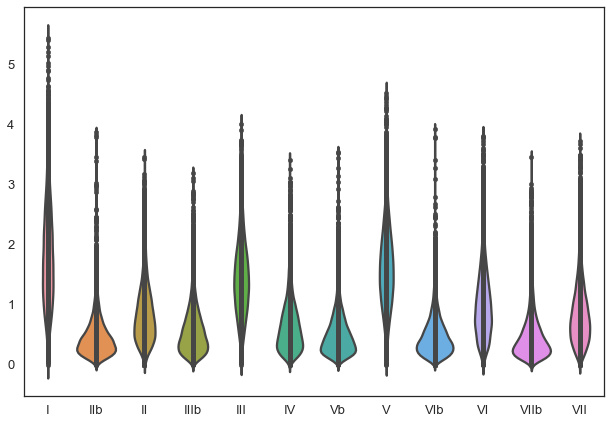

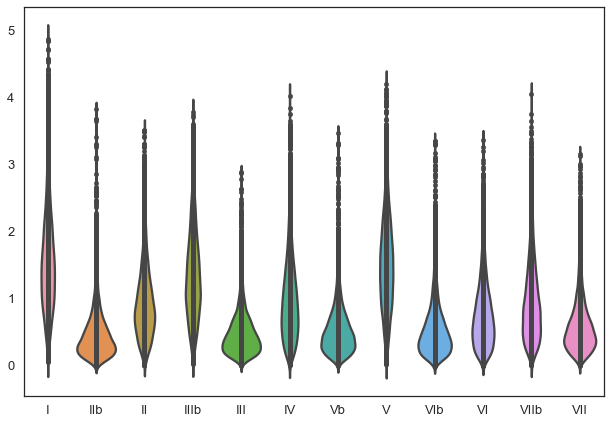

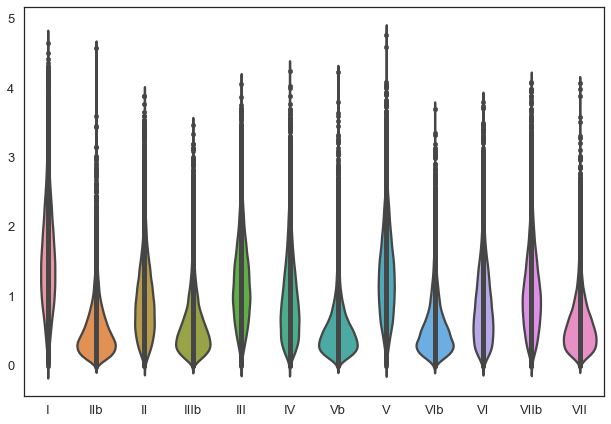

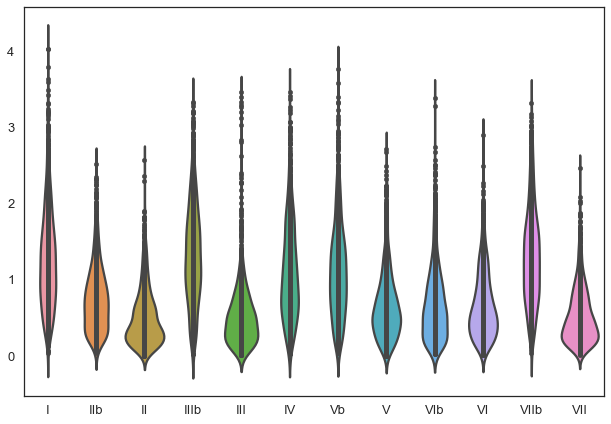

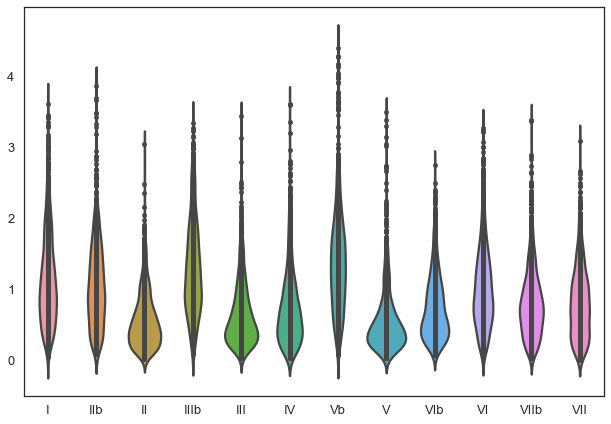

maj 77.9692645445 %
min 70.1673673356 %
dom 52.9434492448 %
hdim7 67.167721519 %
dim 71.0986267166 %
total:  64.5287389605 %
maj BIC:  195403.851089  N:  28
min BIC:  153862.48352  N:  12
dom BIC:  359540.602827  N:  27
hdim7 BIC:  19005.0856283  N:  5
dim BIC:  23294.4585733  N:  6


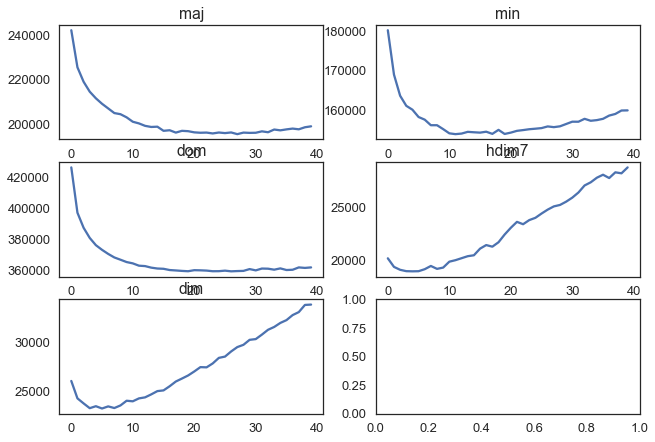

[ 28.  12.  27.   5.   6.]
[ 64.55045689  66.33809493  67.69098939  68.34451454  69.23853525]
[ 64.36787254  66.15027862  67.22971964  67.65117685  68.40403119]


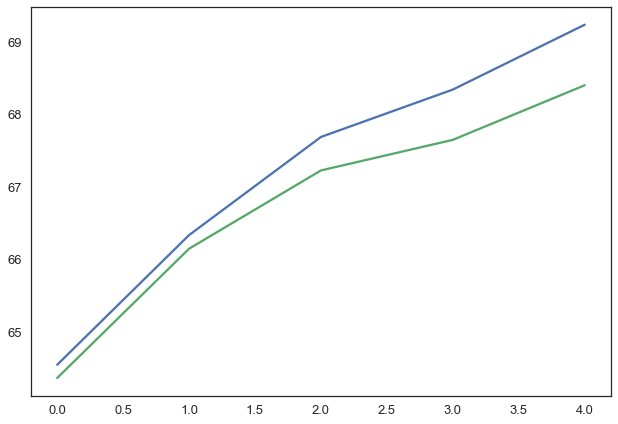

In [10]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../out.npz'))

violinPlots12D(kinds, chromas)
model = fitConstModel(kinds, chromas, [1,1,1,1,1])
trainingScore(model, kinds, chromas)
n_components = findOptimalNComponentsByBIC(chromas)
print n_components


[ 64.55045689  66.33809493  67.69098939  68.34451454  69.23853525
  71.85182547  73.51559601  75.37884409  76.72811885  78.03194833
  83.14994416  87.46078912  92.92103068]
[ 64.36787254  66.15027862  67.22971964  67.65117685  68.40403119
  70.14140387  71.40903583  72.53671261  73.15445343  73.89122919
  75.21356284  75.51276852  75.22964648]


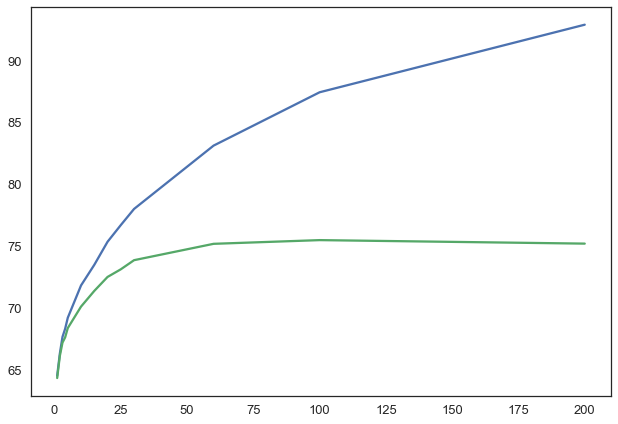

In [42]:
rawTrains, rawTests = trainTestSymmetricalModels(kinds, chromas, symcomponents)
print rawTrains
print rawTests
plt.plot(symcomponents, rawTrains)
plt.plot(symcomponents, rawTests)
plt.show()

In [27]:
def tmp(kinds, chromas, nfolds = 5):
    kf = KFold(n_splits = nfolds, shuffle = True, random_state = 8)
    nfold = 0
    for train_index, test_index in kf.split(chromas):
        train_chromas = chromas[train_index]
        train_labels = labels[train_index]
        train_kinds = kinds[train_index]
        train_mbids = mbids[train_index]
        train_start_times = start_times[train_index]
        train_durations = durations[train_index]
        test_chromas = chromas[test_index]
        test_labels = labels[test_index]
        test_kinds = kinds[test_index]
        test_mbids = mbids[test_index]
        test_start_times = start_times[test_index]
        test_durations = durations[test_index]
        print 100.0 * len(train_chromas[train_kinds=='dim']) / len(train_chromas)
        print 100.0 * len(train_chromas[train_kinds=='hdim7']) / len(train_chromas)
        print 100.0 * len(test_chromas[test_kinds=='dim']) / len(test_chromas)
        print 100.0 * len(test_chromas[test_kinds=='hdim7']) / len(test_chromas)

tmp(kinds, chromas)


2.58596420672
2.0470540921
2.54162309982
1.97860532454
2.54373617535
2.02292378846
2.7105284324
2.07512265744
2.56183390308
2.00281520209
2.63814043272
2.1555537682
2.64422593553
2.04500211136
2.30855855856
1.98680823681
2.54971748004
2.04902374776
2.68661518662
1.97072072072


# Just L1

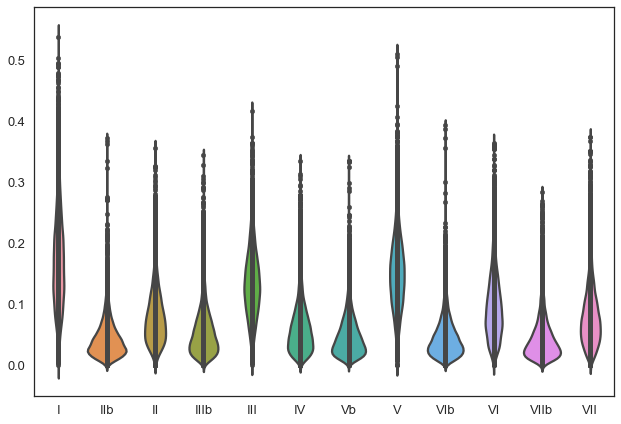

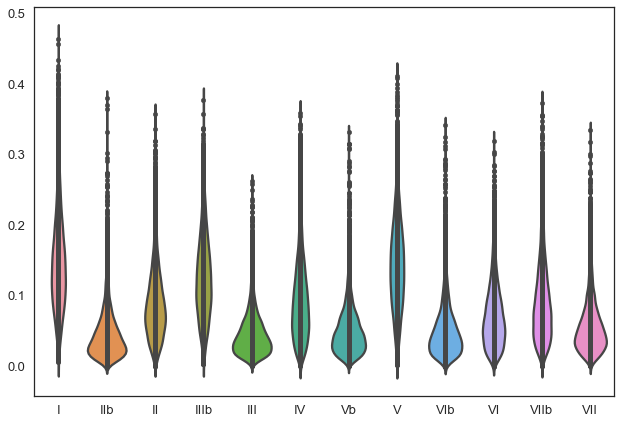

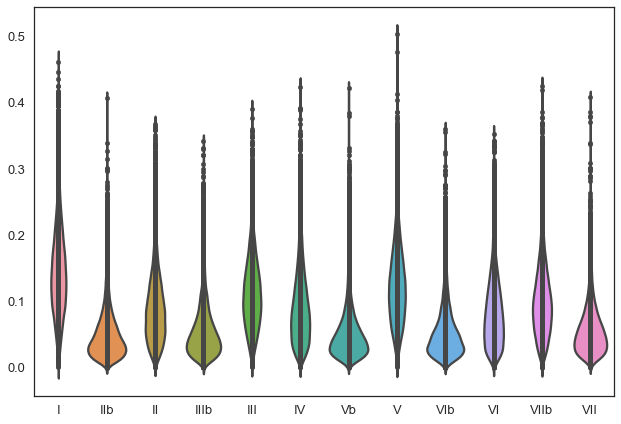

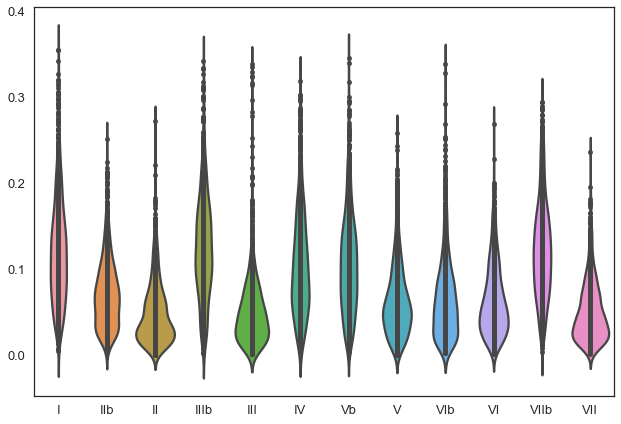

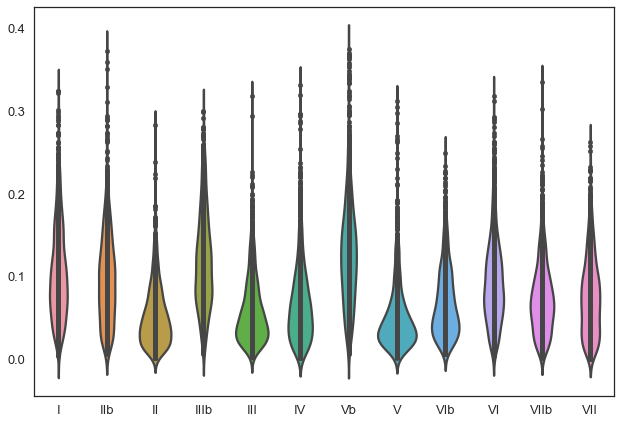

maj 72.7167947311 %
min 74.8473070516 %
dom 47.1022128556 %
hdim7 67.4050632911 %
dim 72.4719101124 %
total:  61.3033476505 %
[ 61.31100162  64.84363644  66.45472631  67.97049735  68.58380393
  70.90632813  72.76595422  74.0512842   75.56182921  76.63803232
  81.73712833  86.00453646  91.83075146]
[ 61.23896     64.5721774   66.1615448   67.58039527  67.89409058
  69.69579533  70.74144157  71.56829577  72.35654278  72.8359254
  74.55238469  74.89344198  74.52021458]


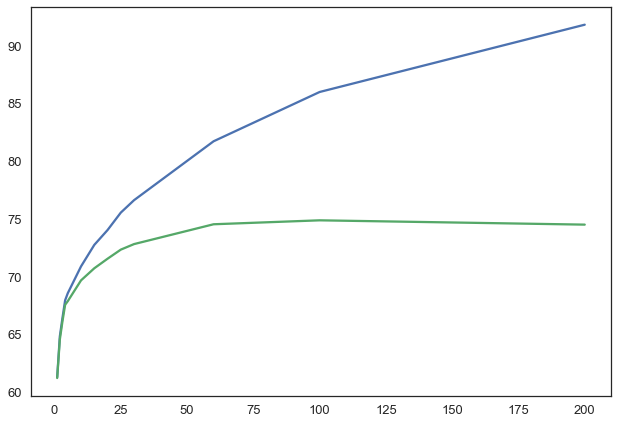

In [30]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../out.npz'))

l1Chromas = normalize(chromas)
violinPlots12D(kinds, l1Chromas)
model = fitConstModel(kinds, l1Chromas, [1,1,1,1,1])
score(model, kinds, l1Chromas, debug=True)
#n_components = findOptimalNComponentsByBIC(l1Chromas)
#print n_components
l1Trains, l1Tests = trainTestSymmetricalModels(kinds, l1Chromas, symcomponents)
print l1Trains
print l1Tests
plt.plot(symcomponents, l1Trains)
plt.plot(symcomponents, l1Tests)
plt.show()



# L2

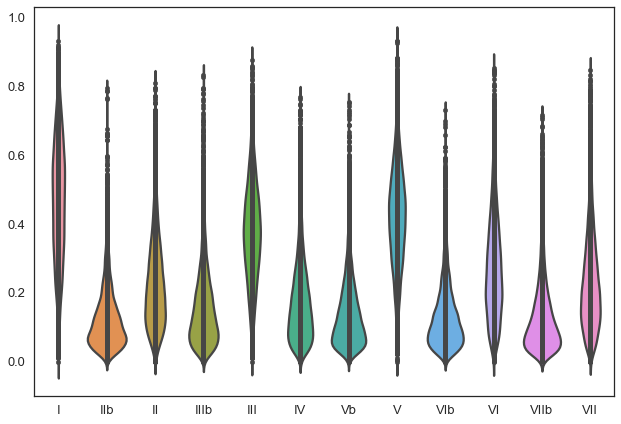

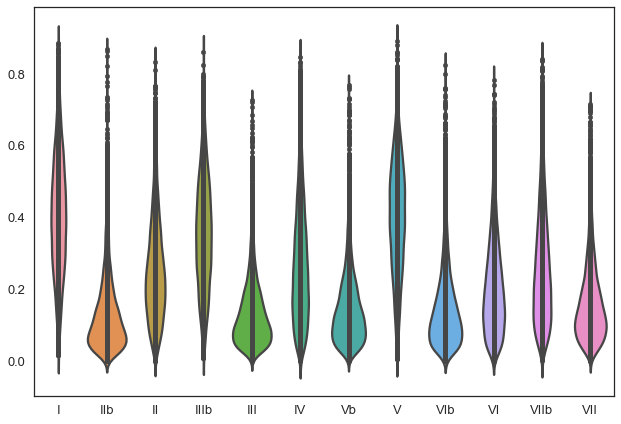

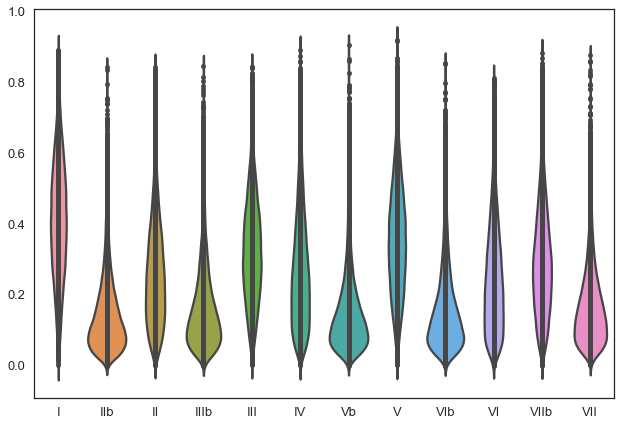

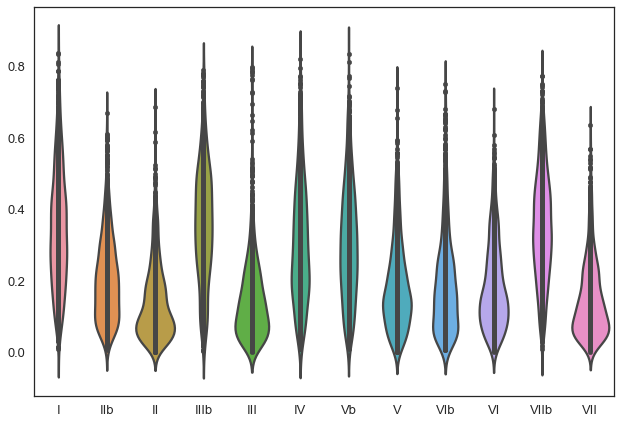

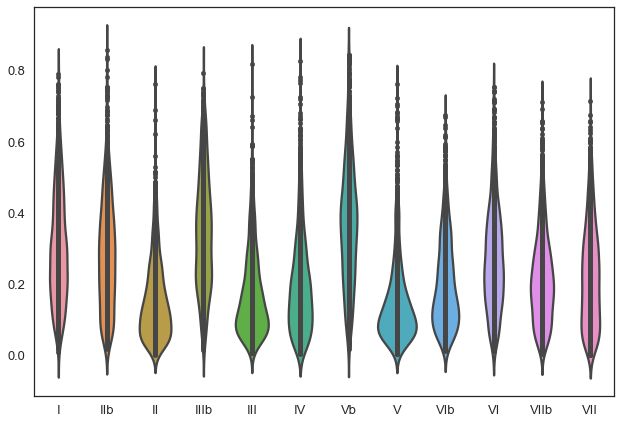

maj 78.5236004391 %
min 69.9532006028 %
dom 52.2690551458 %
hdim7 67.5632911392 %
dim 70.7240948814 %
total:  64.337306758 %
Time span:  1744.16964412
[ 64.31237252  65.37450105  67.14766064  67.73080459  68.24276507
  70.58740677  72.22825442  73.47336796  74.81258961  75.94831206
  80.9034317   85.18451383  91.01515396]
[ 64.25044027  65.09498868  66.71169877  67.14443575  67.58361808
  69.24537723  70.28779975  70.80418029  71.66803889  72.1232923
  73.68531791  73.82044891  73.48744845]


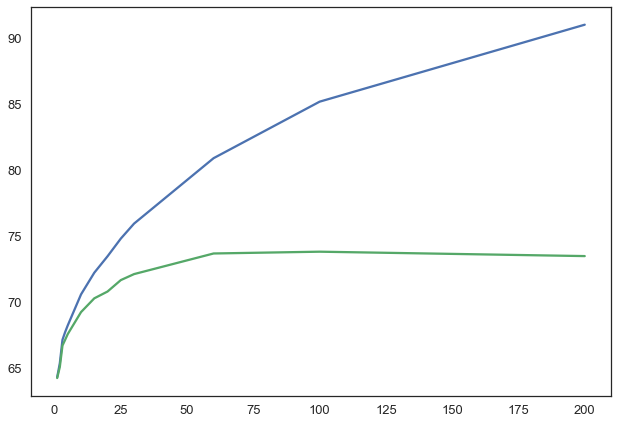

In [34]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../out.npz'))

l2Chromas = normalize(chromas, norm='l2')
violinPlots12D(kinds, l2Chromas)
model = fitConstModel(kinds, l2Chromas, [1,1,1,1,1])
score(model, kinds, l2Chromas, debug=True)
#model = fitConstModel(kinds, l2Chromas, [1,7,2,1,1])
#score(model, kinds, l2Chromas)
#n_components = findOptimalNComponentsByBIC(l2Chromas)
#print n_components
start = time.time()
l2Trains, l2Tests = trainTestSymmetricalModels(kinds, l2Chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l2Trains
print l2Tests
plt.plot(symcomponents, l2Trains)
plt.plot(symcomponents, l2Tests)
plt.show()



# Lmax

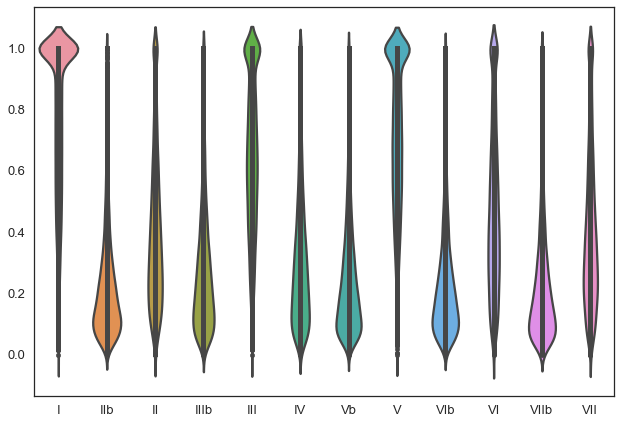

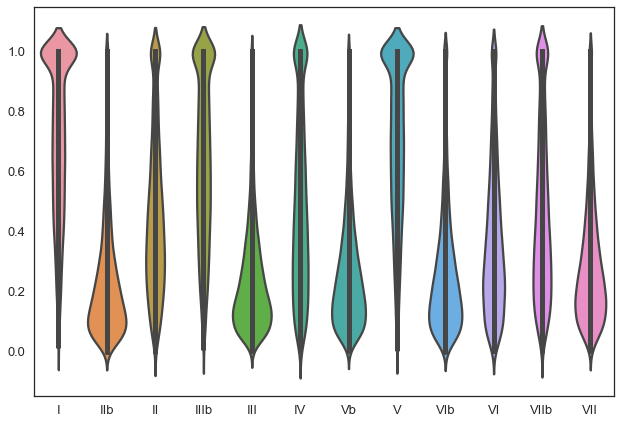

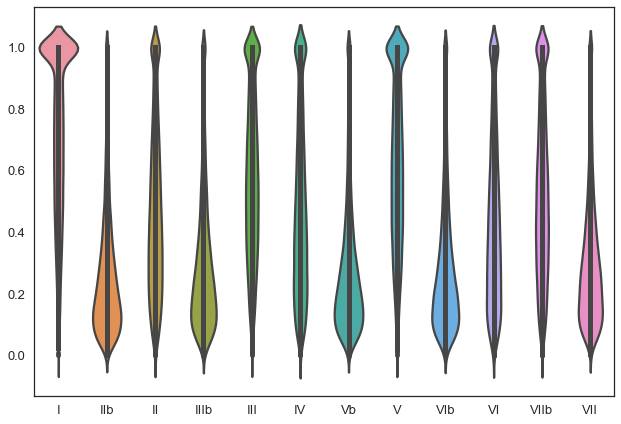

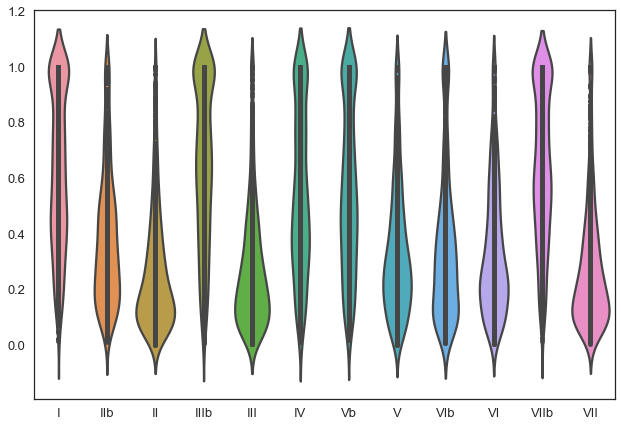

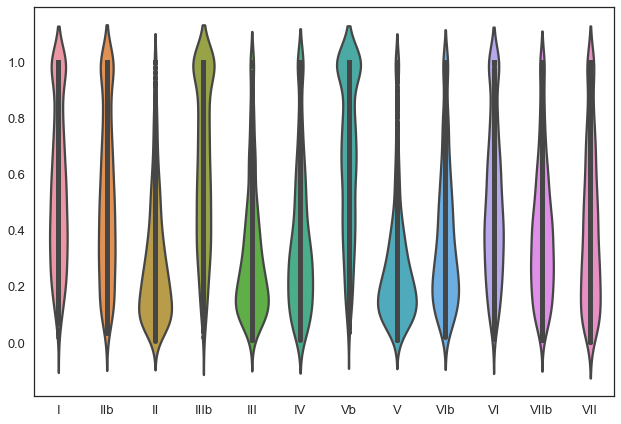

maj 78.2327113063 %
min 69.255175696 %
dom 51.8686336495 %
hdim7 68.3544303797 %
dim 69.6004993758 %
total:  63.9142255039 %
Time span:  1895.54551911
[ 63.91824767  60.51228299  65.49313936  62.46400504  59.27922224
  69.61415816  70.70363471  71.81602941  73.13635192  74.06616377
  77.79668068  80.54348974  85.98643913]
[ 63.80966174  60.27540332  64.95986001  62.12378749  58.75044084
  68.55365609  69.26790299  69.87438927  70.70927701  71.01493167
  72.21177933  72.14742202  72.2873816 ]


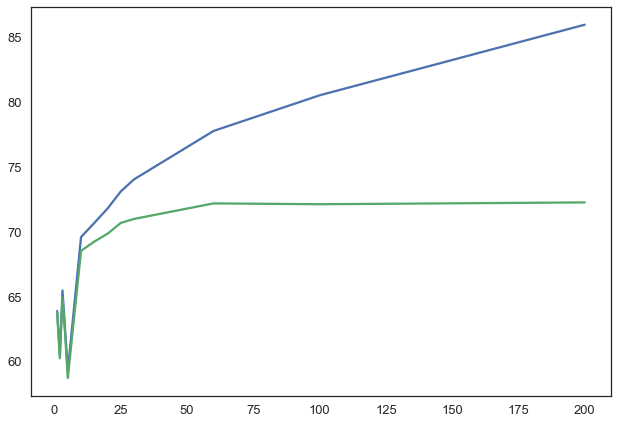

In [36]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../out.npz'))

maxChromas = normalize(chromas, norm='max')
violinPlots12D(kinds, maxChromas)
model = fitConstModel(kinds, maxChromas, [1,1,1,1,1])
score(model, kinds, maxChromas, debug=True)
#model = fitConstModel(kinds, maxChromas, [2,6,1,1,1])
#score(model, kinds, maxChromas)
#n_components = findOptimalNComponentsByBIC(maxChromas)
#print n_components
start = time.time()
maxTrains, maxTests = trainTestSymmetricalModels(kinds, maxChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print maxTrains
print maxTests
plt.plot(symcomponents, maxTrains)
plt.plot(symcomponents, maxTests)
plt.show()

# L1-log

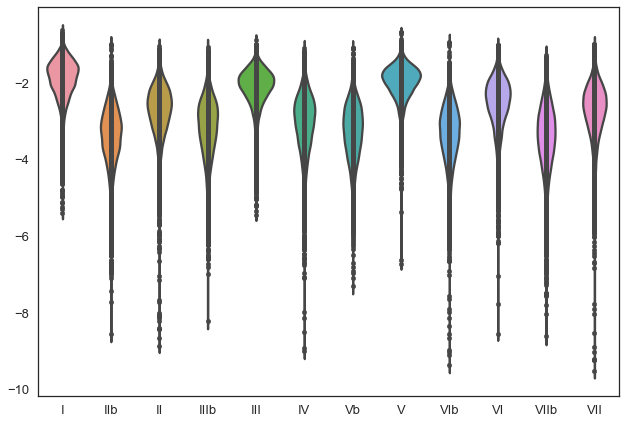

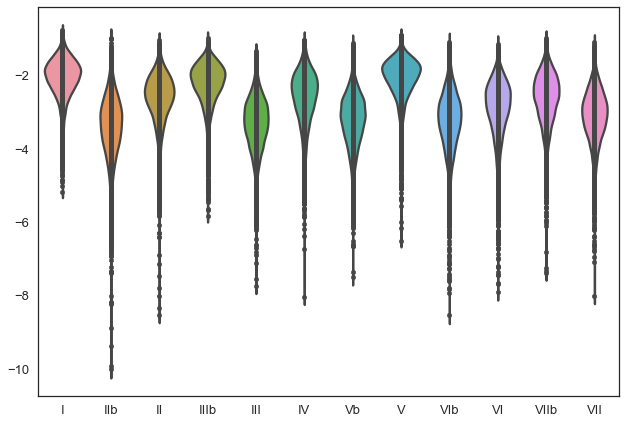

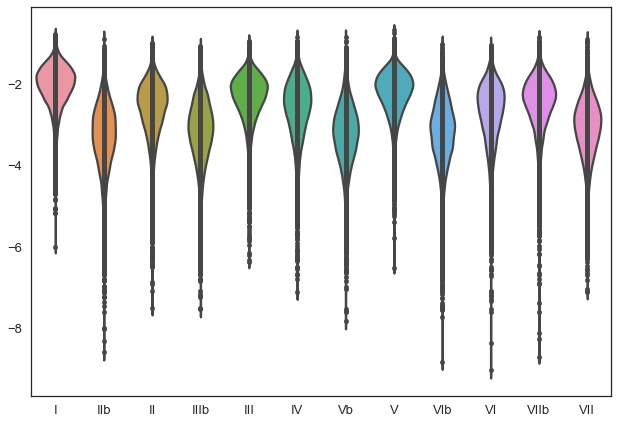

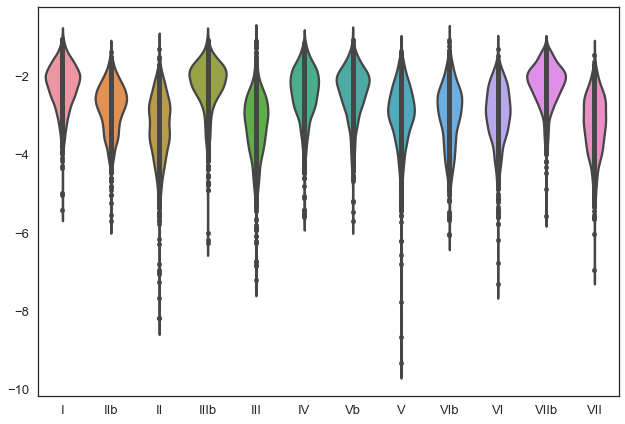

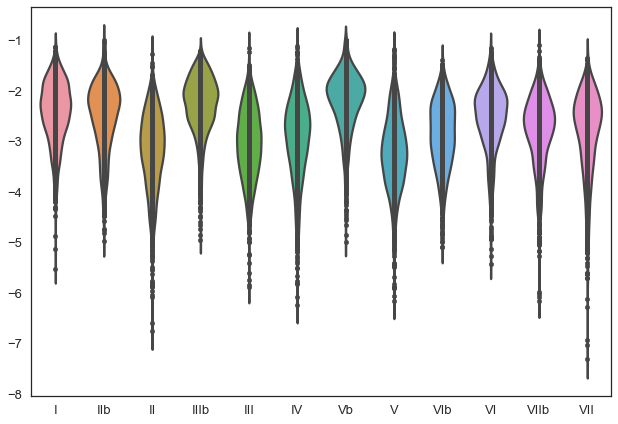

maj 75.6586169045 %
min 73.3243436186 %
dom 61.7421847559 %
hdim7 61.6297468354 %
dim 72.784019975 %
total:  68.4522947734 %
Time span:  2007.97738314
[ 68.47803334  68.07988846  68.91197416  69.0527325   69.67448467
  71.62460049  73.10216718  74.56324548  75.58797098  76.56041428
  81.22556898  85.17928783  90.75173391]
[ 68.34934386  67.72356278  68.45551099  68.34611639  69.02659283
  70.45670055  71.26908427  72.07664057  72.3002564   72.72494211
  74.11644135  74.58939284  74.24513061]


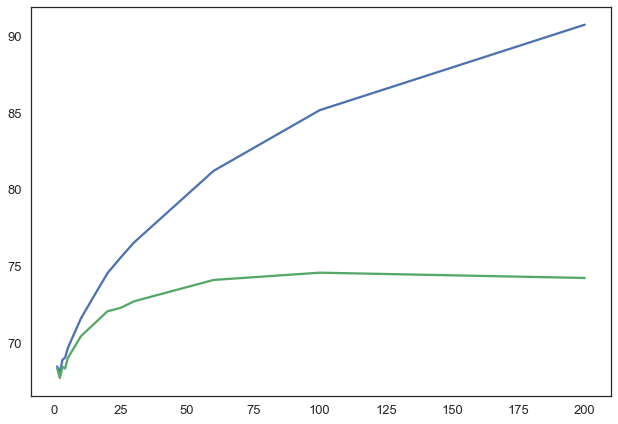

In [37]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../out.npz'))

l1logChromas = logNormalize(chromas)
violinPlots12D(kinds, l1logChromas)
model = fitConstModel(kinds, l1logChromas, [1,1,1,1,1])
score(model, kinds, l1logChromas, debug=True)
#n_components = findOptimalNComponentsByBIC(l1logChromas)
#print n_components
start = time.time()
l1logTrains, l1logTests = trainTestSymmetricalModels(kinds, l1logChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l1logTrains
print l1logTests
plt.plot(symcomponents, l1logTrains)
plt.plot(symcomponents, l1logTests)
plt.show()


# Simplex transform to "free" space

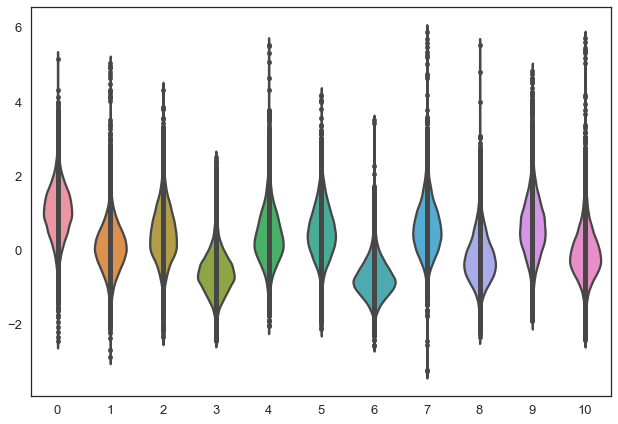

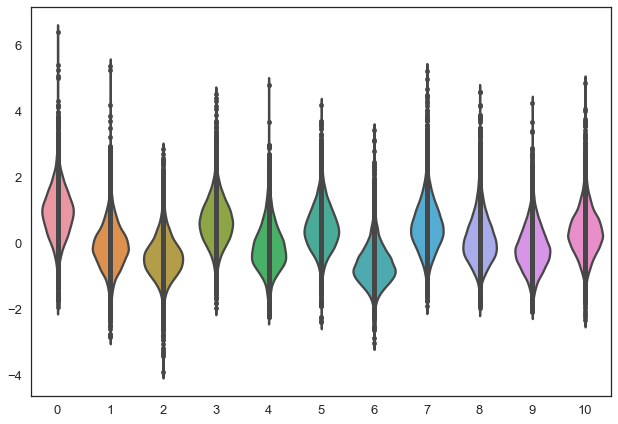

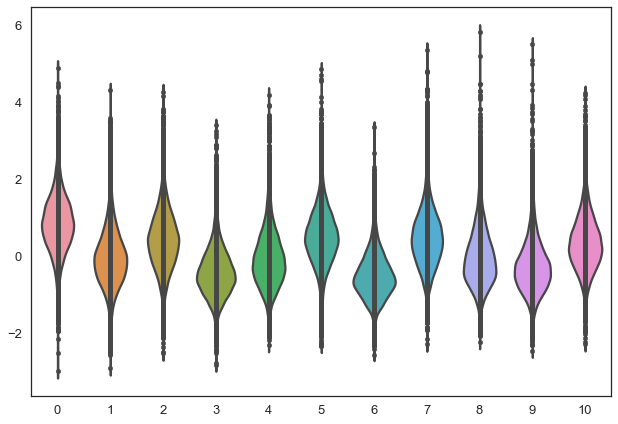

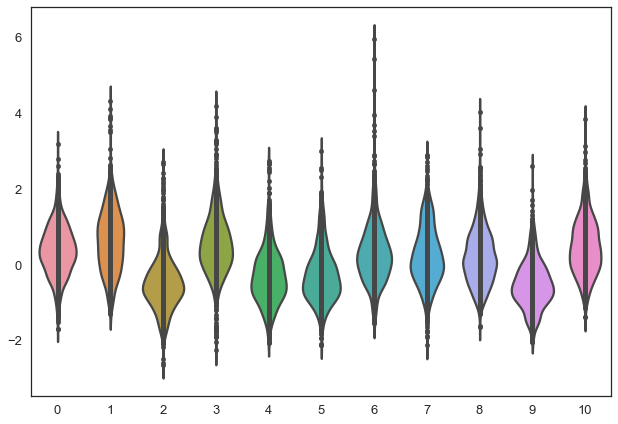

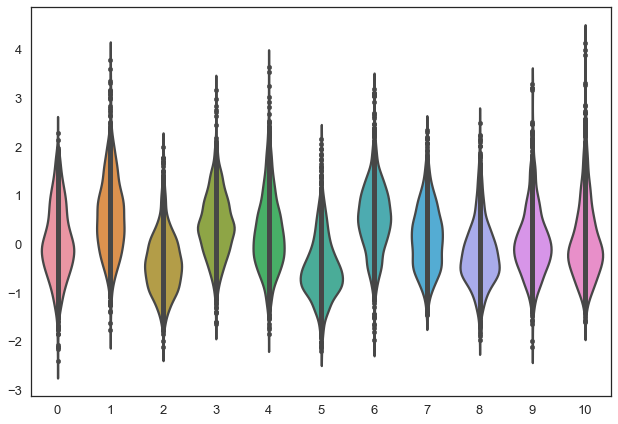

maj 73.0515916575 %
min 72.9832632664 %
dom 62.9293993678 %
hdim7 64.082278481 %
dim 71.7228464419 %
total:  68.1852548944 %
Time span:  2025.81241989
[ 68.17761384  68.49412025  68.88502795  69.4585209   70.19609671
  72.15666834  73.80676635  75.014881    76.21334301  77.37802283
  81.98727693  86.17666465  91.57135262]
[ 68.10804108  68.26085786  68.42815923  69.09897346  69.51079964
  70.90552634  71.78707525  72.53189037  73.0514932   73.41022579
  74.99156069  75.11865284  74.07623019]


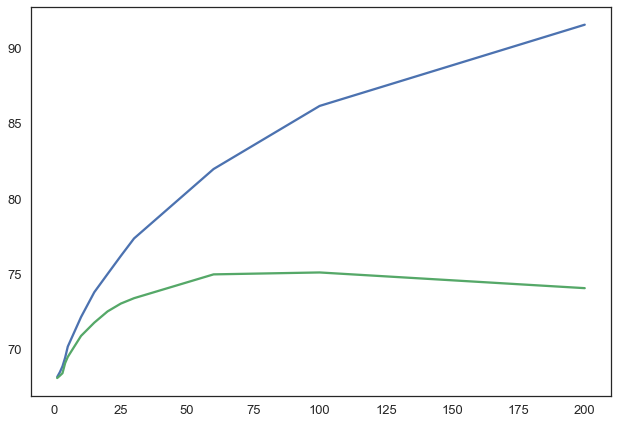

In [38]:
# Compositional data model
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma('../out.npz'))

sxChromas = normalizeTo11d(chromas)
violinPlots11D(kinds, sxChromas)
model = fitConstModel(kinds, sxChromas, [1,1,1,1,1])
trainingScore(model, kinds, sxChromas)
#model = fitConstModel(kinds, sxChromas, [1,3,3,1,1])
#trainingScore(model, kinds, sxChromas)
#n_components = findOptimalNComponentsByBIC(sxChromas)
#print n_components
start = time.time()
sxTrains, sxTests = trainTestSymmetricalModels(kinds, sxChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print sxTrains
print sxTests
plt.plot(symcomponents, sxTrains)
plt.plot(symcomponents, sxTests)
plt.show()




<h1> Recap from previous series.</h1>
I'm working on chord estimation for jazz audio recordings.
Primary task: identify root and chord type:
<ul>
<li> maj
<li> min
<li> dom
<li> hdim7
<li> dim
</ul>

<h2>Idea is to: </h2>
<ul>
<li> detect beats (may be: down beats,  periods by 4, 8 bars, e.g. deeper hierarchy)
<li> for each beat estimate probability of each possible chord
<li> plugin these probabilities into some model to count adjacent chord dependencies
     (and ideally: relation to segments of higher order).
</ul>     

<h2>Done before:</h2>
<ul>
<li> Have 3 datasets ("The Beatles", "Jazz": 62163 beats annotated, "Guitar": 289 beats annotated)
<li> Beat tracking: madmom
<li> NNLS Chroma: appears to be best available as shown with experiment on "The Beatles" dataset.
     Was evaluated only practically.
     Chroma = 12D vector (per value for each semintone pitch class).
<li> Preliminary chroma distribution exploration. Conclusion: after per-sample normalization, it becomes
     very "un Gaussian" (e.g. distributed  in lower dimensional spaece with boundaries, very skewed).
     For L1: it's distributed on simplex. Then, try:
     <ul>
     <li> L1 + logarithm
     <li> L1 + transform to 11D
     </ul>
</ul>

<h2> This week: </h2>
 Fit GMM model to "jazz" and "guitar" dataset. How it's evaluated:
 <ul>
 <li> All chords converted to C (only chord kind is predicted)
 <li> 5-Fold crossvalidation is used
 <li> Naive bayes classifier is applied to trained GMM to detedct chord kind.
 </ul>
 
 <h2> Results: </h2>
 <li> GMM with 60 components gives 75% test accuracy.
      (it's possible to gain almost 100% training accuracy).
      For guitar: 90% test accuracy with simple Gaussian (no mixture).
 <li> NNLS chroma features are not behaved as expected. It seems
      to compress loudness somehow, so normalization isn't necessary.
      It doens't respect perceptual model (masking) and provides counterintuitive
      results. Chroma seems to be a black box now and it's a weak point.
      It seems it could be improved.
 <li> L1 and "Un-simplex": shows better results for low number of components.
      L1 reflects perceptual/musicological approach: (proportions, as in Pitch class profiles). 
      In general, why "unsimplex" is interesting?
      <ul>
      <li> best results for small number of components in GMM
 </ul>

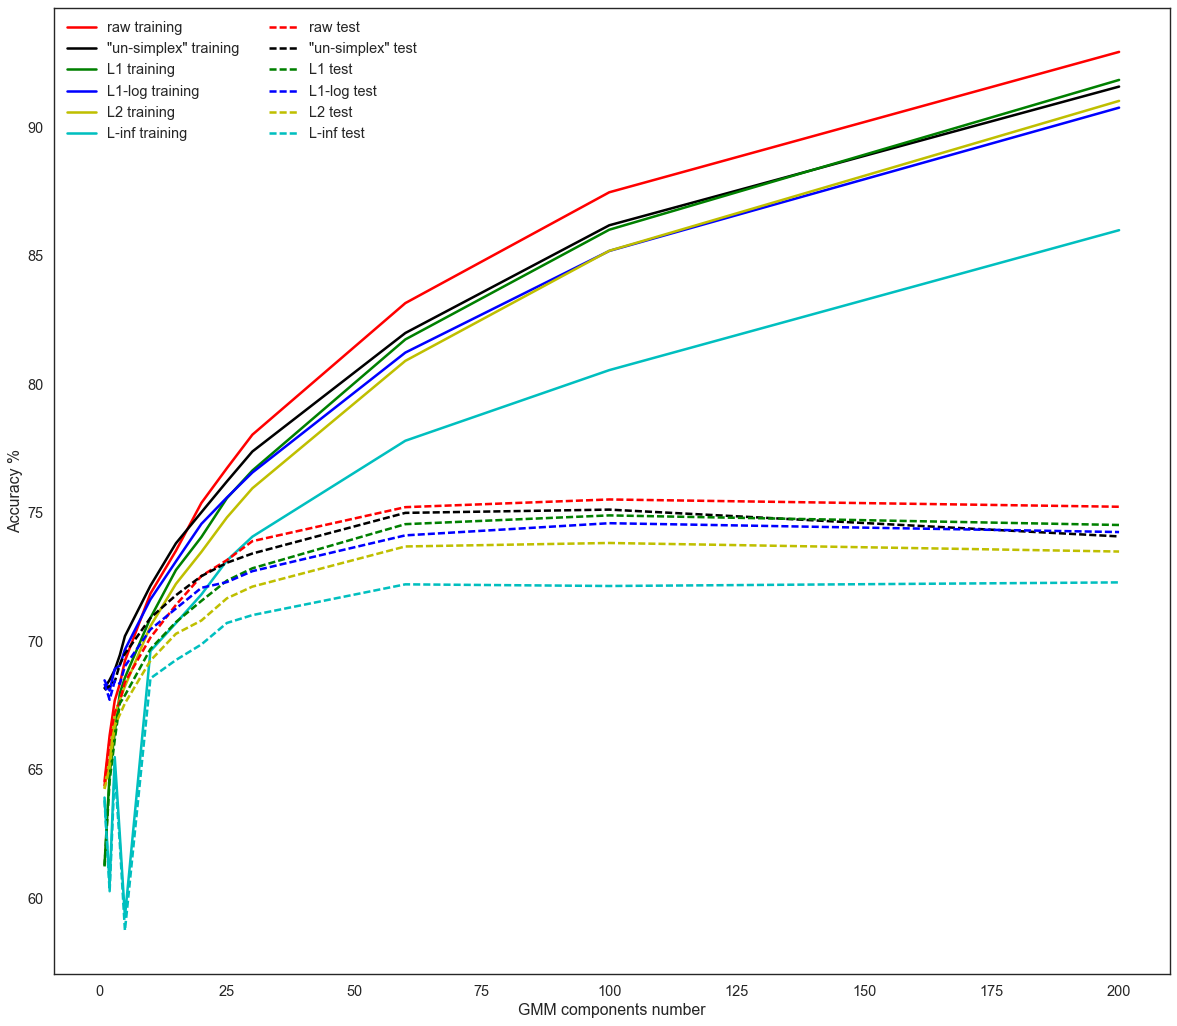

Norm / N of components,1,2,3,4,5,10,15,20,25,30,60,100,200
Raw,64.55,66.34,67.69,68.34,69.24,71.85,73.52,75.38,76.73,78.03,83.15,87.46,92.92
Un-simplex,68.18,68.49,68.89,69.46,70.2,72.16,73.81,75.01,76.21,77.38,81.99,86.18,91.57
L1 training,61.31,64.84,66.45,67.97,68.58,70.91,72.77,74.05,75.56,76.64,81.74,86.0,91.83
L1-log training,68.48,68.08,68.91,69.05,69.67,71.62,73.1,74.56,75.59,76.56,81.23,85.18,90.75
L2 training,64.31,65.37,67.15,67.73,68.24,70.59,72.23,73.47,74.81,75.95,80.9,85.18,91.02
L-inf training,63.92,60.51,65.49,62.46,59.28,69.61,70.7,71.82,73.14,74.07,77.8,80.54,85.99


Norm / N of components,1,2,3,4,5,10,15,20,25,30,60,100,200
Raw,64.37,66.15,67.23,67.65,68.4,70.14,71.41,72.54,73.15,73.89,75.21,75.51,75.23
Un-simplex,68.11,68.26,68.43,69.1,69.51,70.91,71.79,72.53,73.05,73.41,74.99,75.12,74.08
L1 test,61.24,64.57,66.16,67.58,67.89,69.7,70.74,71.57,72.36,72.84,74.55,74.89,74.52
L1-log,68.35,67.72,68.46,68.35,69.03,70.46,71.27,72.08,72.3,72.72,74.12,74.59,74.25
L2 test,64.25,65.09,66.71,67.14,67.58,69.25,70.29,70.8,71.67,72.12,73.69,73.82,73.49
L-inf test,63.81,60.28,64.96,62.12,58.75,68.55,69.27,69.87,70.71,71.01,72.21,72.15,72.29


In [80]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
line, = plt.plot(symcomponents, rawTrains, 'r-')
line.set_label('raw training')
line, = plt.plot(symcomponents, sxTrains, 'k-')
line.set_label('"un-simplex" training')
line, = plt.plot(symcomponents, l1Trains, 'g-')
line.set_label('L1 training')
line, = plt.plot(symcomponents, l1logTrains, 'b-')
line.set_label('L1-log training')
line, = plt.plot(symcomponents, l2Trains, 'y-')
line.set_label('L2 training')
line, = plt.plot(symcomponents, maxTrains, 'c-')
line.set_label('L-inf training')

line, = plt.plot(symcomponents, rawTests, 'r--')
line.set_label('raw test')
line, = plt.plot(symcomponents, sxTests, 'k--')
line.set_label('"un-simplex" test')
line, = plt.plot(symcomponents, l1Tests, 'g--')
line.set_label('L1 test')
line, = plt.plot(symcomponents, l1logTests, 'b--')
line.set_label('L1-log test')
line, = plt.plot(symcomponents, l2Tests, 'y--')
line.set_label('L2 test')
line, = plt.plot(symcomponents, maxTests, 'c--')
line.set_label('L-inf test')

plt.xlabel('GMM components number')
plt.ylabel('Accuracy %')
plt.legend(ncol=2)
plt.show()
from IPython.display import HTML, display
def line2HTML(title, data):
    return '<tr><td>' + title + '</td><td>{}</td></tr>'.format(
        '</td><td>'.join(str(round(x,2)) for x in data))

header = '<tr><th>Norm / N of components</th><th>{}</th></tr>'.format('</th><th>'.join(str(x) for x in symcomponents))
body = ''
body = body + line2HTML('Raw', rawTrains)
body = body + line2HTML('Un-simplex', sxTrains)
body = body + line2HTML('L1 training', l1Trains)
body = body + line2HTML('L1-log training', l1logTrains)
body = body + line2HTML('L2 training', l2Trains)
body = body + line2HTML('L-inf training', maxTrains)
display(HTML('<h3>Training Accuracy %</h3><table>' + header + body + '</table>'))

header = '<tr><th>Norm / N of components</th><th>{}</th></tr>'.format('</th><th>'.join(str(x) for x in symcomponents))
body = ''
body = body + line2HTML('Raw', rawTests)
body = body + line2HTML('Un-simplex', sxTests)
body = body + line2HTML('L1 test', l1Tests)
body = body + line2HTML('L1-log', l1logTests)
body = body + line2HTML('L2 test', l2Tests)
body = body + line2HTML('L-inf test', maxTests)
display(HTML('<h3>Test Accuracy %</h3><table>' + header + body + '</table>'))

1 1716.27470895 True
2 1830.09640434 True
3 1989.71731526 True
4 2135.34247468 True
5 2024.00088365 True
6 2324.12694501 True
7 2226.37446788 True
8 2009.66535912 True
9 2096.83802644 True
10 2072.24304956 True
11 1955.43737868 True
12 1633.21507235 True
13 1411.47601626 True
14 1329.90369808 True
15 1307.41147257 True
16 1316.87447211 True
17 1558.03347869 True
18 1589.9628397 True
19 1725.58212313 True
20 1864.76489599 True
21 1466.12712501 True
22 1616.29956271 True
23 1861.69377689 True
24 1801.14955412 True
25 2123.11467441 True
26 2293.92626492 True
27 2399.56767957 True
28 2512.69671571 True
29 2758.14043282 True
30 3030.96426772 True
31 3275.65719207 True
32 3572.02738431 True
33 3769.38028483 True
34 3731.59328902 True
35 4009.84646066 True
36 4332.48870108 True
37 4654.57358201 True
38 4976.70462767 True
39 5248.86619357 True
40 5521.85151831 True
41 5818.10585029 True
42 6140.62721342 True
43 6370.05966026 True
44 6692.59275472 True
45 6989.25658308 True
46 7312.02946522 Tru

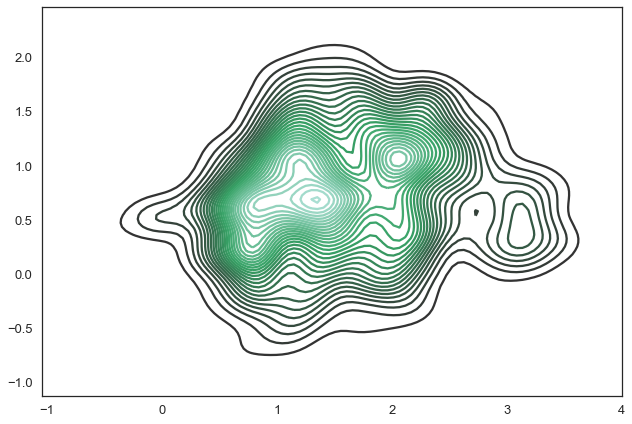

In [21]:
gm = fitMixture(dMaj.values, max_components=50)
gmMaj = gm
print gm.converged_
print gm.bic(dMaj)
print gm.weights_

samples = np.asarray(gm.sample(1000)[0])
samples[:,[0, 9]].shape
sns.kdeplot(samples[:,[0, 9]], n_levels=30)
plt.show()